In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("./retail_store_inventory.csv")
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [3]:
# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Convert appropriate columns to category
cat_cols = ["Store ID", "Product ID", "Category", "Region",
            "Weather Condition", "Seasonality"]

df[cat_cols] = df[cat_cols].astype("category")
df["Holiday/Promotion"] = df["Holiday/Promotion"].astype(bool)

#converted discount to categorical since it is only comprised of 5,10,15,20
df["Discount"] = df["Discount"].astype("category")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  category      
 2   Product ID          73100 non-null  category      
 3   Category            73100 non-null  category      
 4   Region              73100 non-null  category      
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  category      
 11  Weather Condition   73100 non-null  category      
 12  Holiday/Promotion   73100 non-null  bool          
 13  Competitor Pricing  73100 non-null  float64   

## Preprocessing

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

store5_df = df[df["Store ID"] == "S005"]
#PREPARE 
df=store5_df.copy()
# Features and target
target = "Units Sold"
X = df.drop(columns=[target, "Date","Demand Forecast","Competitor Pricing"])  # drop date, can engineer if needed
y = df[target]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["category", "bool"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

#Standardize numeric features for Lasso/Ridge
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first"), categorical_cols)  # drop first to avoid dummy trap
    ]
)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression

ols_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr",LinearRegression())
])

ols_pipeline.fit(X_train, y_train)
ols_pipeline.score(X_test, y_test)

0.359337131763221

# l2 Regularization

## LOOCV

In [6]:
import numpy as np
alphas = np.logspace(-3, 6, 200)  # from 0.001 to 1000
from sklearn.linear_model import RidgeCV

ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge", RidgeCV(alphas=alphas,cv=None,store_cv_results=True))
])

ridge_pipeline.fit(X_train, y_train)
ridge_pipeline.score(X_test, y_test)

0.36042868307411446

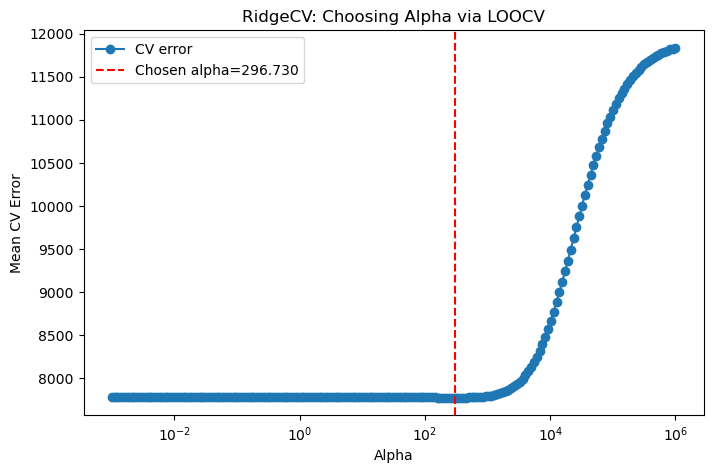

In [7]:
mean_cv_error = ridge_pipeline["ridge"].cv_results_.mean(axis=0)  # shape: (n_alphas,)

plt.figure(figsize=(8, 5))
plt.semilogx(alphas, mean_cv_error, marker="o", label="CV error")
plt.axvline(ridge_pipeline["ridge"].alpha_, color="red", linestyle="--",
            label=f"Chosen alpha={ridge_pipeline['ridge'].alpha_:.3f}")
plt.xlabel("Alpha")
plt.ylabel("Mean CV Error")
plt.title("RidgeCV: Choosing Alpha via LOOCV")
plt.legend()
plt.show()

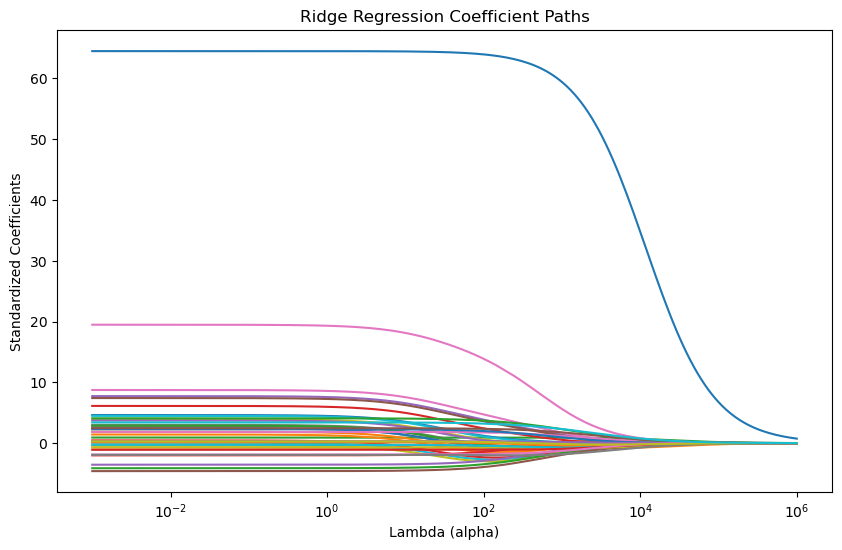

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

coefs = []

for a in alphas:
    ridge_model = Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("ridge", Ridge(alpha=a))
    ])
    ridge_model.fit(X_train, y_train)
    coefs.append(ridge_model["ridge"].coef_)

coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.semilogx(alphas, coefs[:, i], label=f"Feature {i}")

plt.xlabel("Lambda (alpha)")
plt.ylabel("Standardized Coefficients")
plt.title("Ridge Regression Coefficient Paths")
# plt.legend(loc="best", bbox_to_anchor=(1.05, 1))   # optional, can crowd plot
plt.show()


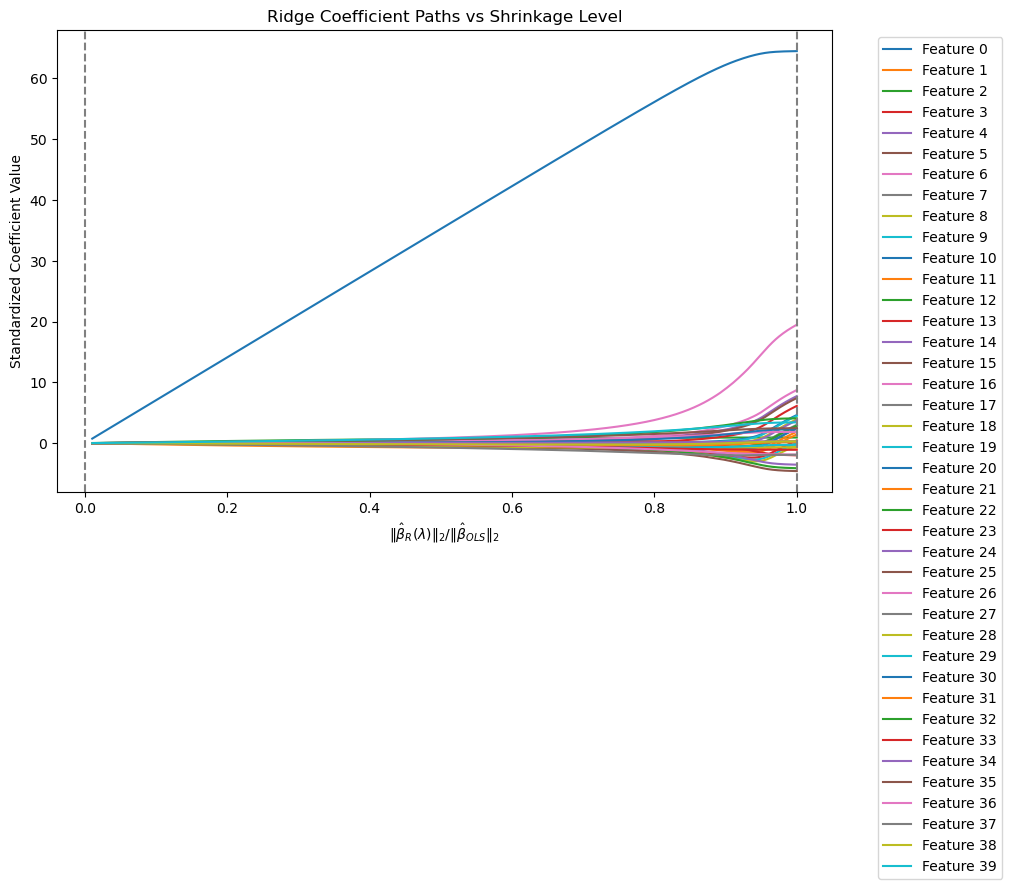

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

# 2. Fit your existing RidgeCV pipeline
ridge_pipeline.fit(X_train, y_train)

# 3. Reuse the fitted preprocessor
preproc = ridge_pipeline.named_steps["preprocessor"]
X_std = preproc.transform(X_train)
X_test_Std=preproc.transform(X_test)

# 4. Fit OLS on standardized X
ols = LinearRegression().fit(X_std, y_train)
beta_ols = ols.coef_
norm_beta_ols = np.linalg.norm(beta_ols)

# 5. Collect ridge paths and norms
coefs = []
shrinkage_index = []

train_errors = []
val_errors = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_std, y_train)
    
    train_errors.append(np.mean((y_train - ridge.predict(X_std))**2))
    val_errors.append(np.mean((y_test - ridge.predict(X_test_Std))**2))  # use held-out validation set
    
    beta_r = ridge.coef_
    coefs.append(beta_r)
    
    # shrinkage index = ||beta_r|| / ||beta_ols||
    shrinkage_index.append(np.linalg.norm(beta_r) / norm_beta_ols)

coefs = np.array(coefs)
shrinkage_index = np.array(shrinkage_index)

# 6. Plot standardized coefficients vs shrinkage index
plt.figure(figsize=(10, 6))

for j in range(coefs.shape[1]):
    plt.plot(shrinkage_index, coefs[:, j], label=f"Feature {j}")

# highlight OLS point
plt.axvline(1.0, color="gray", linestyle="--")
plt.axvline(0.0, color="gray", linestyle="--")

#plt.gca().invert_xaxis()   # so 1 → left and 0 → right like ISLR
plt.xlabel(r"$\|\hat{\beta}_R(\lambda)\|_2 / \|\hat{\beta}_{OLS}\|_2$")
plt.ylabel("Standardized Coefficient Value")
plt.title("Ridge Coefficient Paths vs Shrinkage Level")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.show()


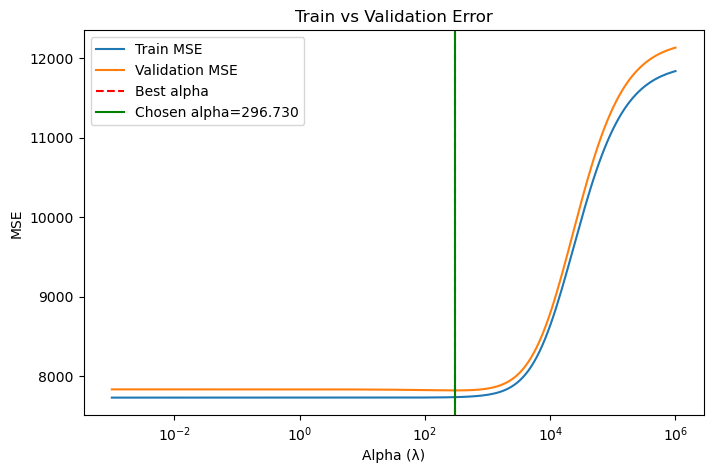

In [10]:
plt.figure(figsize=(8,5))
plt.semilogx(alphas, train_errors, label="Train MSE")
plt.semilogx(alphas, val_errors, label="Validation MSE")
plt.axvline(alphas[np.argmin(val_errors)], color='red', linestyle='--', label="Best alpha")
plt.axvline(ridge_pipeline["ridge"].alpha_, color="green", linestyle="-",
            label=f"Chosen alpha={ridge_pipeline['ridge'].alpha_:.3f}")
plt.xlabel("Alpha (λ)")
plt.ylabel("MSE")
plt.title("Train vs Validation Error")
plt.legend()
plt.show()

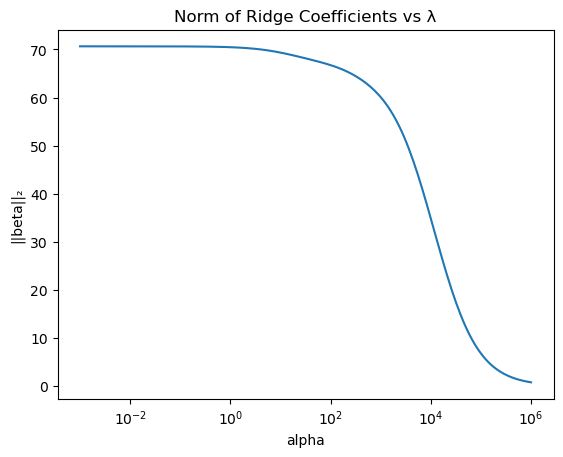

In [11]:
plt.semilogx(alphas, [np.linalg.norm(Ridge(alpha=a).fit(X_std, y_train).coef_) for a in alphas])
plt.xlabel("alpha")
plt.ylabel("||beta||₂")
plt.title("Norm of Ridge Coefficients vs λ")
plt.show()


For our dataset, the Ridge analysis shows that only two coefficients are substantial, with the rest near zero. When plotting standardized coefficients against λ, these two dominate at small λ, and Ridge begins shrinking them around λ ≈ 10²–10⁴, while the others barely change. The shrinkage-level plot confirms that the strong predictors stray from zero early, whereas weaker features only move at high λ. Similarly, the ℓ₂ norm of the Ridge coefficients starts at ~70 (OLS level), decreases moderately in the 10²–10⁴ range, and approaches zero only at extreme λ ≈ 10⁶. This indicates that OLS is already nearly optimal for your data; Ridge mainly provides mild regularization for the dominant coefficients but does not substantially improve predictive performance.

# L1

In [12]:
import numpy as np
alphas = np.logspace(-3, 6, 200)  # from 0.001 to 1000
from sklearn.linear_model import RidgeCV

lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lasso", LassoCV(alphas=alphas,cv=5,max_iter=5000))
])

lasso_pipeline.fit(X_train, y_train)
lasso_pipeline.score(X_test, y_test)

0.36230425164832236

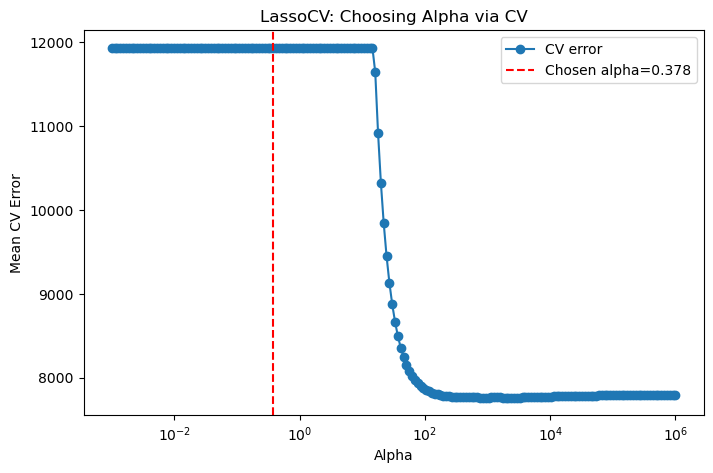

In [13]:
# Compute mean CV error across folds for each alpha
mean_cv_error = lasso_pipeline["lasso"].mse_path_.mean(axis=1)  # shape: (n_alphas,)

plt.figure(figsize=(8, 5))
plt.semilogx(alphas, mean_cv_error, marker="o", label="CV error")
plt.axvline(lasso_pipeline["lasso"].alpha_, color="red", linestyle="--",
            label=f"Chosen alpha={lasso_pipeline['lasso'].alpha_:.3f}")
plt.xlabel("Alpha")
plt.ylabel("Mean CV Error")
plt.title("LassoCV: Choosing Alpha via CV")
plt.legend()
plt.show()


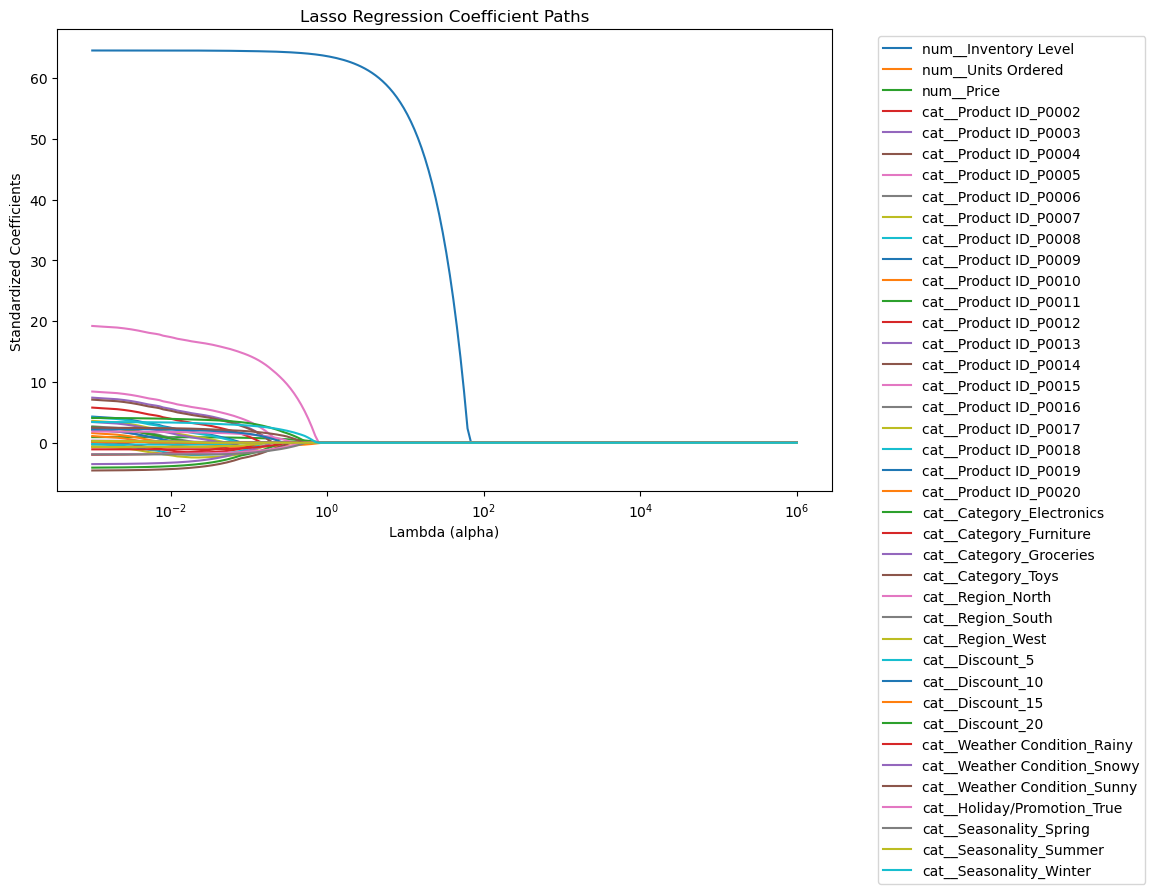

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
import matplotlib.cm as cm

coefs = []
for a in alphas:
    lasso_model = Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("lasso", Lasso(alpha=a, max_iter=5000))
    ])
    lasso_model.fit(X_train, y_train)
    
    coefs.append(lasso_model["lasso"].coef_)

coefs = np.array(coefs)

# 5. Get feature names from preprocessor
feature_names = preproc.get_feature_names_out()

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.semilogx(alphas, coefs[:, i],label=feature_names[i])

plt.xlabel("Lambda (alpha)")
plt.ylabel("Standardized Coefficients")
plt.title("Lasso Regression Coefficient Paths")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))   # optional if too crowded
plt.show()


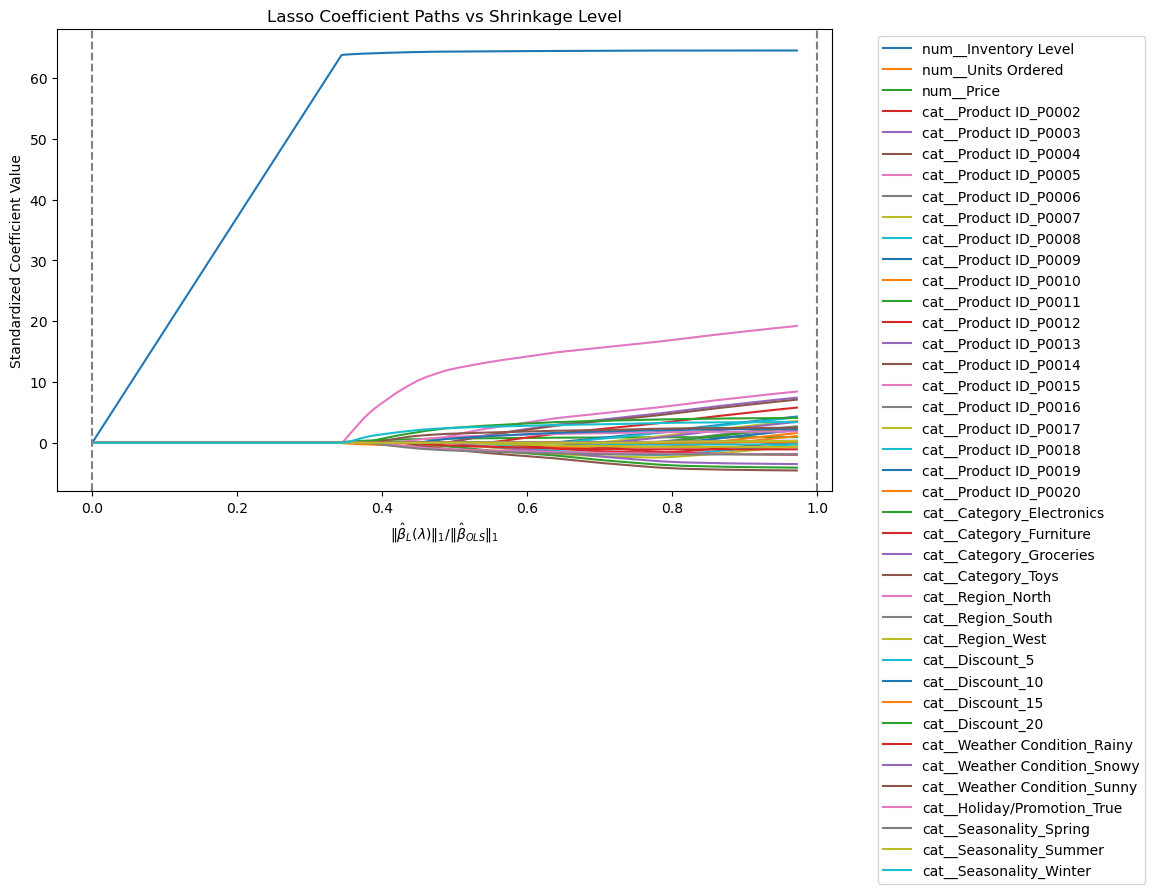

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression

# 1. Fit OLS on standardized X (reuse preprocessor from Ridge pipeline)
preproc = lasso_pipeline.named_steps["preprocessor"]
X_std = preproc.transform(X_train)
X_test_std = preproc.transform(X_test)

ols = LinearRegression().fit(X_std, y_train)
beta_ols = ols.coef_
norm_beta_ols = np.linalg.norm(beta_ols, ord=1)  # use L1 norm for Lasso

# 2. Collect Lasso paths and shrinkage index
coefs = []
shrinkage_index = []
train_errors = []
val_errors = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000)
    lasso.fit(X_std, y_train)
    
    beta_l = lasso.coef_
    coefs.append(beta_l)
    
    shrinkage_index.append(np.linalg.norm(beta_l, ord=1) / norm_beta_ols)

    # compute train and validation MSE
    train_errors.append(np.mean((y_train - lasso.predict(X_std))**2))
    val_errors.append(np.mean((y_test - lasso.predict(X_test_std))**2))


coefs = np.array(coefs)
shrinkage_index = np.array(shrinkage_index)
train_errors = np.array(train_errors)
val_errors = np.array(val_errors)

# 3. Plot standardized coefficients vs shrinkage index
plt.figure(figsize=(10, 6))

for j in range(coefs.shape[1]):
    plt.plot(shrinkage_index, coefs[:, j], label=feature_names[j])

# highlight OLS point
plt.axvline(1.0, color="gray", linestyle="--")
plt.axvline(0.0, color="gray", linestyle="--")

plt.xlabel(r"$\|\hat{\beta}_L(\lambda)\|_1 / \|\hat{\beta}_{OLS}\|_1$")
plt.ylabel("Standardized Coefficient Value")
plt.title("Lasso Coefficient Paths vs Shrinkage Level")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


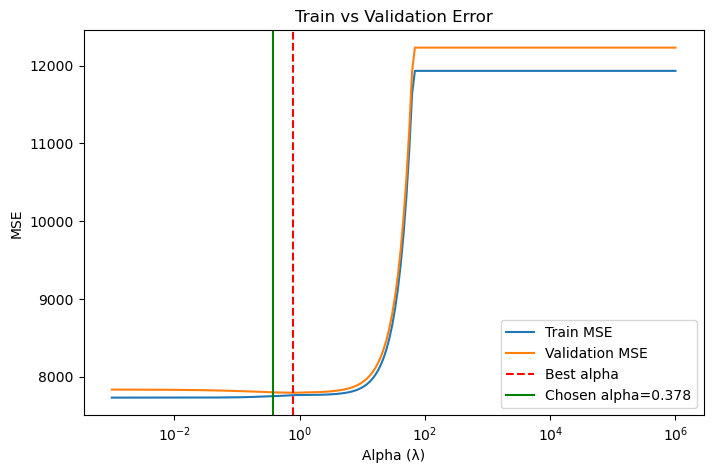

In [16]:
plt.figure(figsize=(8,5))
plt.semilogx(alphas, train_errors, label="Train MSE")
plt.semilogx(alphas, val_errors, label="Validation MSE")
plt.axvline(alphas[np.argmin(val_errors)], color='red', linestyle='--', label="Best alpha")
plt.axvline(lasso_pipeline["lasso"].alpha_, color="green", linestyle="-",
            label=f"Chosen alpha={lasso_pipeline["lasso"].alpha_:.3f}")
plt.xlabel("Alpha (λ)")
plt.ylabel("MSE")
plt.title("Train vs Validation Error")
plt.legend()
plt.show()

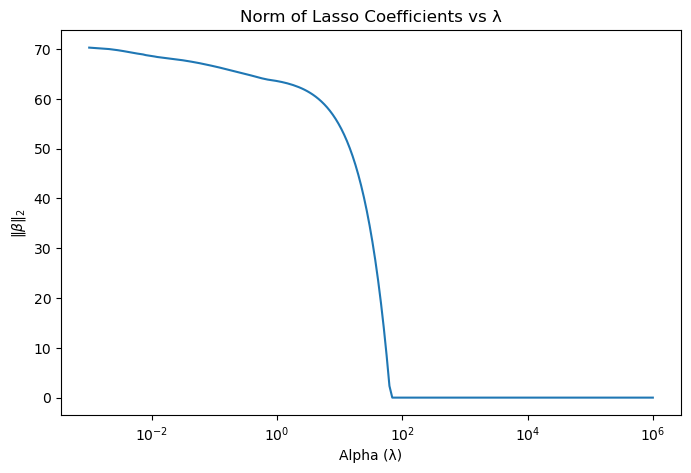

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

plt.figure(figsize=(8, 5))

plt.semilogx(
    alphas, 
    [np.linalg.norm(Lasso(alpha=a, max_iter=10000).fit(X_std, y_train).coef_) for a in alphas]
)

plt.xlabel("Alpha (λ)")
plt.ylabel(r"$\|\beta\|_2$")
plt.title("Norm of Lasso Coefficients vs λ")
plt.show()


For our dataset, the Lasso analysis shows a clear sparsity pattern: most coefficients remain near zero across all λ, while one starts around 20 and decreases near λ ≈ 1, and another starts above 60 and drops around λ ≈ 10². The shrinkage-level plot (||β_L(λ)||₁ / ||β_OLS||₁) confirms that the strongest predictor begins shrinking early, the second strong predictor strays around 0.2–0.4, and the rest stay near zero. The ℓ₂ norm of the Lasso coefficients starts at ~70 (OLS level) and declines around λ ≈ 10², reflecting progressive regularization. Overall, Lasso effectively selects the dominant predictors while pushing weaker ones to zero, indicating it may outperform OLS by providing both feature selection and variance reduction.